In [1]:
#%matplotlib notebook

import pandas
from datetime import datetime
import numpy
import matplotlib.pyplot as pyplot
from ipywidgets import widgets
from ipywidgets import interact
#import pickle
#import dill

import quandl
import scipy
import sklearn.linear_model
import sklearn.metrics

Source of the file is EIA.GOV. Great source of free data.

Price of Heating Oil (Dollars per Gallon)
===============================
The history goes from 1990. Unfortunately they only have heating oil price weekly and from Oct-Mar (Winter)

In [2]:
df_ny = pandas.read_csv("Weekly_New_York_No._2_Heating_Oil_Residential_Price.csv",skiprows=4)
df_nj = pandas.read_csv("Weekly_New_Jersey_No._2_Heating_Oil_Residential_Price.csv",skiprows=4)
df_ct = pandas.read_csv("Weekly_Connecticut_No._2_Heating_Oil_Residential_Price.csv",skiprows=4)
#print("Number of records (weeks) available (NY):", len(df_ny))
#print("Number of records (weeks) available (NJ):", len(df_nj))
#print("Number of records (weeks) available (CT):", len(df_ct))

In [3]:
dfs = [ df_ny, df_nj, df_ct ]
for df in dfs:
    #print(df.columns)
    df.columns = ['Date','DPG']
    df['Date'] = pandas.to_datetime(df['Date'])
    #print(df.tail(3))
for df in dfs:
    #df['Week'] = df['Date'].dt.isocalendar().week
    df['Week'] = df['Date'].dt.strftime("%W").astype(int)
    #df['Year'] = df['Date'].dt.isocalendar().year
    df['Year'] = df['Date'].dt.strftime("%Y").astype(int)
    df['Season'] = ((df['Date'].dt.month-1) // 3)
    df['TagY'] = df['Year']-1*(df['Season']==0)
    df['TagW'] = df['Week']+52*(df['Year']-df['TagY'])-40
filters_ny = []
tags_ny = []
for X in df_ny["TagY"].unique():
    tags_ny.append( X )
    filters_ny.append( (df_ny["TagY"]==X) )

filters_nj = []
tags_nj = []
for X in df_nj["TagY"].unique():
    tags_nj.append( X )
    filters_nj.append( (df_nj["TagY"]==X) )

filters_ct = []
tags_ct = []
for X in df_ct["TagY"].unique():
    tags_ct.append( X )
    filters_ct.append( (df_ct["TagY"]==X) )

filters = [ filters_ny, filters_nj, filters_ct ]
tags = [ tags_ny, tags_nj, tags_ct ]

Imports of Crude Oil (Thousands of Barrels)
===================================

In [4]:
df_im = pandas.read_csv("Imports_of_all_grades_to_New_York-2.csv",skiprows=4)
#df_im.head()

In [5]:
imports_nj = df_im.loc[[2]].melt(id_vars=["<span style='float:right;'>(thousand barrels)</span>"], var_name="Date", value_name="Barrels")[["Date","Barrels"]]
imports_ny = df_im.loc[[3]].melt(id_vars=["<span style='float:right;'>(thousand barrels)</span>"], var_name="Date", value_name="Barrels")[["Date","Barrels"]]
imports_ny["Barrels"] = imports_ny["Barrels"].str.replace("--", "0")
imports_nj["Barrels"] = imports_nj["Barrels"].str.replace("--", "0")
imports_ny["Barrels"] = imports_ny["Barrels"].astype(int)
imports_nj["Barrels"] = imports_nj["Barrels"].astype(int)
imports_ny["Date"] = pandas.to_datetime(imports_ny["Date"])
imports_nj["Date"] = pandas.to_datetime(imports_nj["Date"])
#imports_ny.head()

Production of Crude Oil (Thousands of Barrels)
=====================================

In [6]:
production_ny = pandas.read_csv("New_York_Field_Production_of_Crude_Oil.csv",skiprows=4)
production_ny.columns = ['Date','Barrels']
production_ny["Barrels"] = production_ny["Barrels"].astype(int)
production_ny["Date"] = pandas.to_datetime( production_ny["Date"] )
#production_ny.head()

Data Inspection
=============


In [7]:
#df_ny.head(30)

In [8]:
#df_ny["Season"].value_counts()

In [9]:
#df_ny[["TagW","Week","TagY","Year","Season","Date"]].value_counts()

In [10]:
#(df_ny["Year"]-df_ny["TagY"]).unique()

Preview of Uncook Data
===================
Plot all data as it comes to check integrity, among other things =)

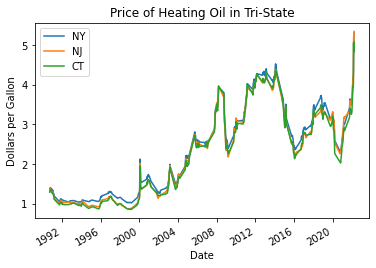

In [11]:
ax = df_ny.plot(x="Date",y="DPG",label="NY")
df_nj.plot(x="Date",y="DPG",label="NJ",ax=ax)
df_ct.plot(x="Date",y="DPG",label="CT",ax=ax)
#pyplot.axvline(x = datetime(2022,2,24), color = 'b', label = 'Russia-Ucraine')
#pyplot.axvline(x = datetime(2021,1,20), color = 'r', label = 'Biden')
#pyplot.axvline(x = datetime(2020,3,13), color = 'y', label = 'COVID Pandemic')
#pyplot.xlim([datetime(2008,7,1), datetime(2022,5,1)])
#pyplot.xlim([datetime(2018,7,1), datetime(2022,5,1)])
#pyplot.ylim(2, 5.5)
pyplot.ylabel("Dollars per Gallon")
pyplot.title("Price of Heating Oil in Tri-State")
#pyplot.plot
#ax.plot(logy=True, logx=True)

ax.legend()

In [12]:
df_nj.tail()

,Date,DPG,Week,Year,Season,TagY,TagW
678,1990-12-03,1.346,49,1990,3,1990,9
679,1990-11-19,1.341,47,1990,3,1990,7
680,1990-11-05,1.360,45,1990,3,1990,5
681,1990-10-15,1.377,42,1990,3,1990,2
682,1990-10-01,1.317,40,1990,3,1990,0


Text(0.5, 1.0, 'Imports from Overseas')

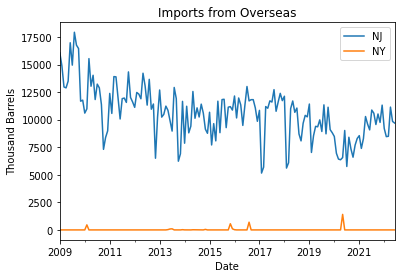

In [13]:
ax = imports_nj.plot(x="Date",y="Barrels",label="NJ")
imports_ny.plot(x="Date",y="Barrels",ax=ax,label="NY")
#pyplot.xlim([datetime(2008,7,1), datetime(2022,5,1)])
pyplot.ylabel("Thousand Barrels")
pyplot.title("Imports from Overseas")

Text(0.5, 1.0, 'Production in NewYork')

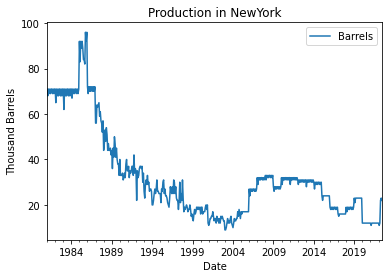

In [14]:
production_ny.plot(x="Date",y="Barrels")
#pyplot.xlim([datetime(2008,7,1), datetime(2022,5,1)])
pyplot.ylabel("Thousand Barrels")
pyplot.title("Production in NewYork")

Unifying Data
===========
I want to define what I call HeatingOilSeason, for lack of a better term. The HeatingOilSeason begins in October on one year and extends until March of the next year. Two varaibles are use for tagging:
    TagY: Year where the HeatingOilSeason begined
    TagW: Week (from 0 to 20) within the HeatingOilSeason

In [15]:
def plot_tagY(dftuple):
    def plotter(Winter):
        df, flts = dftuple[0]
        valid_rows = df[flts[Winter]].notna()
        ax = df[flts[Winter]].plot(x="TagW", y="DPG", label="NY")
        df, flts = dftuple[1]
        valid_rows = df[flts[Winter]].notna()
        df[flts[Winter]].plot(x="TagW", y="DPG", label="NJ", ax=ax)
        df, flts = dftuple[2]
        valid_rows = df[flts[Winter]].notna()
        df[flts[Winter]].plot(x="TagW", y="DPG", label="CT", ax=ax)
        pyplot.ylabel("Dollars Per Gallon")
        pyplot.xlabel("Week number in Winter Season")
        pyplot.title("Oct {0} to Mar {1}".format( 2021-Winter, 2022-Winter ) )
        #pyplot.ylim([1, 6])    
        ax.legend()
    return plotter

In [16]:
tags = []
for X in df_ny["TagY"].unique():
    tags.append( X )
all_df = [ (df_ny,filters_ny), (df_nj,filters_nj), (df_ct,filters_ct) ]
dropdown_values = {"{0}".format(flt):k for k, flt in enumerate(tags)}
widgets.interact(plot_tagY(all_df), Winter=dropdown_values);

interactive(children=(Dropdown(description='Winter', options={'2021': 0, '2020': 1, '2019': 2, '2018': 3, '201…

In [17]:
df_ny.head()

,Date,DPG,Week,Year,Season,TagY,TagW
0,2022-03-28,5.315,13,2022,0,2021,25
1,2022-03-21,5.004,12,2022,0,2021,24
2,2022-03-14,5.001,11,2022,0,2021,23
3,2022-03-07,5.017,10,2022,0,2021,22
4,2022-02-28,4.256,9,2022,0,2021,21


In [18]:
filt = df_ny['Date'] > datetime(2018,7,1)

ddf_ny = df_ny.loc[ filt, ['Week','DPG'] ]

In [19]:
week_groups_mean = ddf_ny.groupby("Week").mean()
type(week_groups_mean)

pandas.core.frame.DataFrame

<AxesSubplot:xlabel='Week'>

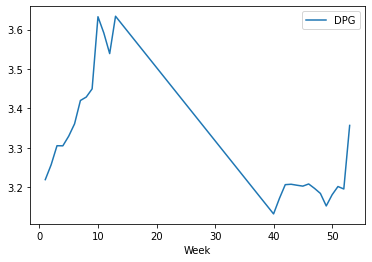

In [20]:
week_groups_mean.plot(y="DPG", use_index=True)

In [21]:
datetime(1196, 12, 31, 0, 0, 0).strftime("%W")

'53'